In [1]:
%matplotlib notebook
import h5py
from torch.autograd import Variable
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data as data
import torchvision.models as models
import torch.nn.functional as F
import torch.nn.init as init
from torch.nn.utils.rnn import pack_padded_sequence
import torchvision.transforms as transforms
import os
import sys
import os.path
import math
import re
import torch
from PIL import Image
from tqdm import tqdm
from collections import Counter
import itertools
import json
from matplotlib import pyplot as plt
preprocessed_path = 'pre/resnet-14x14.h5'
vocabulary_path='pre/voca.json'
glove_path="glove.6B.300d.txt"

val_q_path="/datasets/ee285f-public/VQA2017/v2_OpenEnded_mscoco_val2014_questions.json"
val_a_path="/datasets/ee285f-public/VQA2017/v2_mscoco_val2014_annotations.json"
train_q_path="/datasets/ee285f-public/VQA2017/v2_OpenEnded_mscoco_train2014_questions.json"
train_a_path="/datasets/ee285f-public/VQA2017/v2_mscoco_train2014_annotations.json"

batch_size = 128
max_answers = 3000
output_features=2048
image_size = 448  
output_size = image_size // 32  

In [2]:
"""
Neural Network tools developed for UCSD ECE285 MLIP.

Copyright 2019. Charles Deledalle, Sneha Gupta, Anurag Paul, Inderjot Saggu.
"""

import os
import time
import torch
from torch import nn
import torch.utils.data as td
from abc import ABC, abstractmethod


class NeuralNetwork(nn.Module, ABC):
    """An abstract class representing a neural network.

    All other neural network should subclass it. All subclasses should override
    ``forward``, that makes a prediction for its input argument, and
    ``criterion``, that evaluates the fit between a prediction and a desired
    output. This class inherits from ``nn.Module`` and overloads the method
    ``named_parameters`` such that only parameters that require gradient
    computation are returned. Unlike ``nn.Module``, it also provides a property
    ``device`` that returns the current device in which the network is stored
    (assuming all network parameters are stored on the same device).
    """

    def __init__(self):
        super(NeuralNetwork, self).__init__()

    @property
    def device(self):
        # This is important that this is a property and not an attribute as the
        # device may change anytime if the user do ``net.to(newdevice)``.
        return next(self.parameters()).device

    def named_parameters(self, recurse=True):
        nps = nn.Module.named_parameters(self)
        for name, param in nps:
            if not param.requires_grad:
                continue
            yield name, param

    @abstractmethod
    def forward(self, **x):
        pass

    @abstractmethod
    def criterion(self, y, d):
        pass


class StatsManager(object):
    """
    A class meant to track the loss during a neural network learning experiment.

    Though not abstract, this class is meant to be overloaded to compute and
    track statistics relevant for a given task. For instance, you may want to
    overload its methods to keep track of the accuracy, top-5 accuracy,
    intersection over union, PSNR, etc, when training a classifier, an object
    detector, a denoiser, etc.
    """

    def __init__(self):
        self.init()

    def __repr__(self):
        """Pretty printer showing the class name of the stats manager. This is
        what is displayed when doing ``print(stats_manager)``.
        """
        return self.__class__.__name__

    def init(self):
        """Initialize/Reset all the statistics"""
        self.running_loss = 0
        self.number_update = 0

    def accumulate(self, loss, x=None, y=None, d=None):
        """Accumulate statistics

        Though the arguments x, y, d are not used in this implementation, they
        are meant to be used by any subclasses. For instance they can be used
        to compute and track top-5 accuracy when training a classifier.

        Arguments:
            loss (float): the loss obtained during the last update.
            x (Tensor): the input of the network during the last update.
            y (Tensor): the prediction of by the network during the last update.
            d (Tensor): the desired output for the last update.
        """
        self.running_loss += loss
        self.number_update += 1
        print("loss", loss)

    def summarize(self):
        """Compute statistics based on accumulated ones"""
        return self.running_loss / self.number_update

def collate_fn(batch):
    # put question lengths in descending order so that we can use packed sequences later
    batch.sort(key=lambda x: x[-1], reverse=True)
    return data.dataloader.default_collate(batch)
class Experiment(object):
    """
    A class meant to run a neural network learning experiment.

    After being instantiated, the experiment can be run using the method
    ``run``. At each epoch, a checkpoint file will be created in the directory
    ``output_dir``. Two files will be present: ``checkpoint.pth.tar`` a binary
    file containing the state of the experiment, and ``config.txt`` an ASCII
    file describing the setting of the experiment. If ``output_dir`` does not
    exist, it will be created. Otherwise, the last checkpoint will be loaded,
    except if the setting does not match (in that case an exception will be
    raised). The loaded experiment will be continued from where it stopped when
    calling the method ``run``. The experiment can be evaluated using the method
    ``evaluate``.

    Attributes/Properties:
        epoch (integer): the number of performed epochs.
        history (list): a list of statistics for each epoch.
            If ``perform_validation_during_training``=False, each element of the
            list is a statistic returned by the stats manager on training data.
            If ``perform_validation_during_training``=True, each element of the
            list is a pair. The first element of the pair is a statistic
            returned by the stats manager evaluated on the training set. The
            second element of the pair is a statistic returned by the stats
            manager evaluated on the validation set.

    Arguments:
        net (NeuralNetork): a neural network.
        train_set (Dataset): a training data set.
        val_set (Dataset): a validation data set.
        stats_manager (StatsManager): a stats manager.
        output_dir (string, optional): path where to load/save checkpoints. If
            None, ``output_dir`` is set to "experiment_TIMESTAMP" where
            TIMESTAMP is the current time stamp as returned by ``time.time()``.
            (default: None)
        batch_size (integer, optional): the size of the mini batches.
            (default: 16)
        perform_validation_during_training (boolean, optional): if False,
            statistics at each epoch are computed on the training set only.
            If True, statistics at each epoch are computed on both the training
            set and the validation set. (default: False)
    """

    def __init__(self, net, train_set, val_set, optimizer, stats_manager,
                 output_dir=None, batch_size=16, perform_validation_during_training=False):
        self.total_iterations = 0
        # Define data loaders
        train_loader = td.DataLoader(train_set, batch_size=batch_size, shuffle=True,
                                     pin_memory=True, collate_fn=collate_fn)
        val_loader = td.DataLoader(val_set, batch_size=batch_size, shuffle=False,
                                   pin_memory=True, collate_fn=collate_fn)

        # Initialize history
        history = []

        # Define checkpoint paths
        if output_dir is None:
            output_dir = 'experiment_{}'.format(time.time())
        os.makedirs(output_dir, exist_ok=True)
        checkpoint_path = os.path.join(output_dir, "checkpoint.pth.tar")
        config_path = os.path.join(output_dir, "config.txt")

        # Transfer all local arguments/variables into attributes
        locs = {k: v for k, v in locals().items() if k is not 'self'}
        self.__dict__.update(locs)

        # Load checkpoint and check compatibility
        if os.path.isfile(config_path):
#            with open(config_path, 'r') as f:
#                print(repr(self))
#               if f.read()[:-1] != repr(self):
#                    raise ValueError(
#                        "Cannot create this experiment: "
#                        "I found a checkpoint conflicting with the current setting.")
            self.load()
        else:
            self.save()

    @property
    def epoch(self):
        """Returns the number of epochs already performed."""
        return len(self.history)

    def update_learning_rate(self, optimizer, iteration):
        lr = 1e-3 * 0.5**(float(iteration) / 50000)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr


    
    
    def setting(self):
        """Returns the setting of the experiment."""
        return {'Net': self.net,
                'Optimizer': self.optimizer,
                'StatsManager': self.stats_manager,
                'BatchSize': self.batch_size,
                'PerformValidationDuringTraining': self.perform_validation_during_training}

    def __repr__(self):
        """Pretty printer showing the setting of the experiment. This is what
        is displayed when doing ``print(experiment)``. This is also what is
        saved in the ``config.txt`` file.
        """
        string = ''
        for key, val in self.setting().items():

            string += '{}({})\n'.format(key, val)
        return string

    def state_dict(self):
        """Returns the current state of the experiment."""
        return {'Net': self.net.state_dict(),
                'Optimizer': self.optimizer.state_dict(),
                'History': self.history}

    def load_state_dict(self, checkpoint):
        """Loads the experiment from the input checkpoint."""
        self.net.load_state_dict(checkpoint['Net'])
        self.optimizer.load_state_dict(checkpoint['Optimizer'])
        self.history = checkpoint['History']

        # The following loops are used to fix a bug that was
        # discussed here: https://github.com/pytorch/pytorch/issues/2830
        # (it is supposed to be fixed in recent PyTorch version)
        for state in self.optimizer.state.values():
            for k, v in state.items():
                if isinstance(v, torch.Tensor):
                    state[k] = v.to(self.net.device)

    def save(self):
        """Saves the experiment on disk, i.e, create/update the last checkpoint."""
        torch.save(self.state_dict(), self.checkpoint_path)
        with open(self.config_path, 'w') as f:
            print(self, file=f)

    def load(self):
        """Loads the experiment from the last checkpoint saved on disk."""
        checkpoint = torch.load(self.checkpoint_path,
                                map_location=self.net.device)
        self.load_state_dict(checkpoint)
        del checkpoint

    def run(self, num_epochs, plot=None):
        """Runs the experiment, i.e., trains the network using backpropagation
        based on the optimizer and the training set. Also performs statistics at
        each epoch using the stats manager.

        Arguments:
            num_epoch (integer): the number of epoch to perform.
            plot (func, optional): if not None, should be a function taking a
                single argument being an experiment (meant to be ``self``).
                Similar to a visitor pattern, this function is meant to inspect
                the current state of the experiment and display/plot/save
                statistics. For example, if the experiment is run from a
                Jupyter notebook, ``plot`` can be used to display the evolution
                of the loss with ``matplotlib``. If the experiment is run on a
                server without display, ``plot`` can be used to show statistics
                on ``stdout`` or save statistics in a log file. (default: None)
        """
        self.net.train()
        self.stats_manager.init()
        start_epoch = self.epoch
        print("Start/Continue training from epoch {}".format(start_epoch))
        if plot is not None:
            plot(self)
        for epoch in range(start_epoch, num_epochs):
            s = time.time()
            self.stats_manager.init()
            itr = 0
            itr_s = time.time()
            for v, q, a, item, q_length in self.train_loader:
                run_t=time.time()-itr_s
                itr_s = time.time()
                self.update_learning_rate(self.optimizer,self.total_iterations)
                self.total_iterations+=1
                v, q, a, item, q_length = v.to(self.net.device), q.to(self.net.device), a.to(self.net.device), item.to(self.net.device), q_length.to(self.net.device)
                self.optimizer.zero_grad()
                y = self.net.forward([v, q, q_length])
                loss = self.net.criterion(y, a)
                loss.backward()
                self.optimizer.step()
                with torch.no_grad():
                    self.stats_manager.accumulate(loss.item(), y=y, d=a)
                print("Epoch {} Iter {} (Time: {:.2f}s)".format(
                self.epoch, itr, run_t))
                itr+=1
            if not self.perform_validation_during_training:
                self.history.append(self.stats_manager.summarize())
            else:
                self.history.append(
                    (self.stats_manager.summarize(), self.evaluate()))
            print("Epoch {} (Time: {:.2f}s)".format(
                self.epoch, time.time() - s))
            self.save()
            if plot is not None:
                plot(self)
        print("Finish training for {} epochs".format(num_epochs))

    def evaluate(self):
        """Evaluates the experiment, i.e., forward propagates the validation set
        through the network and returns the statistics computed by the stats
        manager.
        """
        self.stats_manager.init()
        self.net.eval()
        with torch.no_grad():
            for v, q, a, item, q_length in self.val_loader:
                v, q, a, item, q_length = v.to(self.net.device), q.to(self.net.device), a.to(self.net.device), item.to(self.net.device), q_length.to(self.net.device)
                y = self.net.forward([v, q, q_length])
                loss = self.net.criterion(y, a)
                self.stats_manager.accumulate(loss.item(), y=y, d=a)
        self.net.train()
        return self.stats_manager.summarize()

In [3]:

# this is used for normalizing questions
_special_chars = re.compile('[^a-z0-9 ]*')

# these try to emulate the original normalization scheme for answers
_period_strip = re.compile(r'(?!<=\d)(\.)(?!\d)')
_comma_strip = re.compile(r'(\d)(,)(\d)')
_punctuation_chars = re.escape(r';/[]"{}()=+\_-><@`,?!')
_punctuation = re.compile(r'([{}])'.format(re.escape(_punctuation_chars)))
_punctuation_with_a_space = re.compile(r'(?<= )([{0}])|([{0}])(?= )'.format(_punctuation_chars))


def prepare_questions(questions_json):
    """ Tokenize and normalize questions from a given question json in the usual VQA format. """
    questions = [q['question'] for q in questions_json['questions']]
    for question in questions:
        question = question.lower()[:-1]
        yield question.split(' ')
        
def prepare_answers(answers_json):
    """ Normalize answers from a given answer json in the usual VQA format. """
    answers = [[a['answer'] for a in ans_dict['answers']] for ans_dict in answers_json['annotations']]
    # The only normalization that is applied to both machine generated answers as well as
    # ground truth answers is replacing most punctuation with space (see [0] and [1]).
    # Since potential machine generated answers are just taken from most common answers, applying the other
    # normalizations is not needed, assuming that the human answers are already normalized.
    # [0]: http://visualqa.org/evaluation.html
    # [1]: https://github.com/VT-vision-lab/VQA/blob/3849b1eae04a0ffd83f56ad6f70ebd0767e09e0f/PythonEvaluationTools/vqaEvaluation/vqaEval.py#L96

    def process_punctuation(s):
        # the original is somewhat broken, so things that look odd here might just be to mimic that behaviour
        # this version should be faster since we use re instead of repeated operations on str's
        if _punctuation.search(s) is None:
            return s
        s = _punctuation_with_a_space.sub('', s)
        if re.search(_comma_strip, s) is not None:
            s = s.replace(',', '')
        s = _punctuation.sub(' ', s)
        s = _period_strip.sub('', s)
        return s.strip()

    for answer_list in answers:
        yield list(map(process_punctuation, answer_list))





In [4]:
class VQA(data.Dataset):
    """ VQA dataset, open-ended """
    def __init__(self, questions_path, answers_path, image_features_path, vocabulary_path, answerable_only=False):
        super(VQA, self).__init__()
        with open(questions_path, 'r') as fd:
            questions_json = json.load(fd)
        with open(answers_path, 'r') as fd:
            answers_json = json.load(fd)
        with open(vocabulary_path, 'r') as fd:
            vocab_json = json.load(fd)
        self._check_integrity(questions_json, answers_json)

        # vocab
        self.vocab = vocab_json
        self.token_to_index = self.vocab['question']
        self.answer_to_index = self.vocab['answer']

        # q and a
        self.questions = list(prepare_questions(questions_json))
        self.answers = list(prepare_answers(answers_json))
        self.questions = [self._encode_question(q) for q in self.questions]
        self.answers = [self._encode_answers(a) for a in self.answers]

        # v
        self.image_features_path = image_features_path
        self.coco_id_to_index = self._create_coco_id_to_index()
        self.coco_ids = [q['image_id'] for q in questions_json['questions']]

        # only use questions that have at least one answer?
        self.answerable_only = answerable_only
        if self.answerable_only:
            self.answerable = self._find_answerable()

    @property
    def max_question_length(self):
        if not hasattr(self, '_max_length'):
            self._max_length = max(map(len, self.questions))
        return self._max_length

    @property
    def num_tokens(self):
        return len(self.token_to_index) + 1  # add 1 for <unknown> token at index 0

    def _create_coco_id_to_index(self):
        """ Create a mapping from a COCO image id into the corresponding index into the h5 file """
        with h5py.File(self.image_features_path, 'r') as features_file:
            coco_ids = features_file['ids'][()]
        coco_id_to_index = {id: i for i, id in enumerate(coco_ids)}
        return coco_id_to_index

    def _check_integrity(self, questions, answers):
        """ Verify that we are using the correct data """
        qa_pairs = list(zip(questions['questions'], answers['annotations']))
        assert all(q['question_id'] == a['question_id'] for q, a in qa_pairs), 'Questions not aligned with answers'
        assert all(q['image_id'] == a['image_id'] for q, a in qa_pairs), 'Image id of question and answer don\'t match'
        assert questions['data_type'] == answers['data_type'], 'Mismatched data types'
        assert questions['data_subtype'] == answers['data_subtype'], 'Mismatched data subtypes'

    def _find_answerable(self):
        """ Create a list of indices into questions that will have at least one answer that is in the vocab """
        answerable = []
        for i, answers in enumerate(self.answers):
            answer_has_index = len(answers.nonzero()) > 0
            # store the indices of anything that is answerable
            if answer_has_index:
                answerable.append(i)
        return answerable

    def _encode_question(self, question):
        """ Turn a question into a vector of indices and a question length """
        vec = torch.zeros(self.max_question_length).long()
        for i, token in enumerate(question):
            index = self.token_to_index.get(token, 0)
            vec[i] = index
        return vec, len(question)

    def _encode_answers(self, answers):
        """ Turn an answer into a vector """
        # answer vec will be a vector of answer counts to determine which answers will contribute to the loss.
        # this should be multiplied with 0.1 * negative log-likelihoods that a model produces and then summed up
        # to get the loss that is weighted by how many humans gave that answer
        answer_vec = torch.zeros(len(self.answer_to_index))
        for answer in answers:
            index = self.answer_to_index.get(answer)
            if index is not None:
                answer_vec[index] += 1
        return answer_vec

    def _load_image(self, image_id):
        """ Load an image """
        if not hasattr(self, 'features_file'):
            # Loading the h5 file has to be done here and not in __init__ because when the DataLoader
            # forks for multiple works, every child would use the same file object and fail
            # Having multiple readers using different file objects is fine though, so we just init in here.
            self.features_file = h5py.File(self.image_features_path, 'r')
        index = self.coco_id_to_index[image_id]
        dataset = self.features_file['features']
        img = dataset[index].astype('float32')
        return torch.from_numpy(img)

    def __getitem__(self, item):
        if self.answerable_only:
            # change of indices to only address answerable questions
            item = self.answerable[item]

        q, q_length = self.questions[item]
        a = self.answers[item]
        image_id = self.coco_ids[item]
        v = self._load_image(image_id)
        # since batches are re-ordered for PackedSequence's, the original question order is lost
        # we return `item` so that the order of (v, q, a) triples can be restored if desired
        # without shuffling in the dataloader, these will be in the order that they appear in the q and a json's.
        return v, q, a, item, q_length

    def __len__(self):
        if self.answerable_only:
            return len(self.answerable)
        else:
            return len(self.questions)

In [5]:
class Net(NeuralNetwork):
    """ Re-implementation of ``Show, Ask, Attend, and Answer: A Strong Baseline For Visual Question Answering'' [0]
    [0]: https://arxiv.org/abs/1704.03162
    """

    def __init__(self, embedding_tokens):
        super(Net, self).__init__()
        question_features = 1024
        vision_features = output_features
        glimpses = 2
        self.softmax = nn.LogSoftmax()

        self.text = TextProcessor(
            embedding_tokens=embedding_tokens,
            embedding_features=300,
            gru_features=question_features,
            drop=0.5,
        )
        self.attention = Attention(
            v_features=vision_features,
            q_features=question_features,
            mid_features=512,
            glimpses=2,
            drop=0.5,
        )
        self.classifier = Classifier(
            in_features=glimpses * vision_features + question_features,
            mid_features=1024,
            out_features=max_answers,
            drop=0.5,
        )

        for m in self.modules():
            if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
                init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    m.bias.data.zero_()

    def criterion(self, y, d):
        loss = (-self.softmax(y) * d / 10).sum(dim=1).mean()
        return loss
        
    def forward(self, x):
        v, q, q_len = x
        q = self.text(q, list(q_len.data))

        v = v / (v.norm(p=2, dim=1, keepdim=True).expand_as(v) + 1e-8)
        a = self.attention(v, q)
        v = apply_attention(v, a)

        combined = torch.cat([v, q], dim=1)
        answer = self.classifier(combined)
        return answer


class Classifier(nn.Sequential):
    def __init__(self, in_features, mid_features, out_features, drop=0.0):
        super(Classifier, self).__init__()
        self.add_module('drop1', nn.Dropout(drop))
        self.add_module('lin1', nn.Linear(in_features, mid_features))
        self.add_module('relu', nn.ReLU())
        self.add_module('drop2', nn.Dropout(drop))
        self.add_module('lin2', nn.Linear(mid_features, out_features))


class TextProcessor(nn.Module):
    def __init__(self, embedding_tokens, embedding_features, gru_features, drop=0.0):
        super(TextProcessor, self).__init__()
        self.embedding = nn.Embedding(embedding_tokens, embedding_features, padding_idx=0)
        self.drop = nn.Dropout(drop)
        self.tanh = nn.Tanh()
        self.lstm = nn.LSTM(input_size=embedding_features,
                            hidden_size=gru_features,
                            num_layers=1)
        self.features = gru_features

        self._init_gru(self.lstm.weight_ih_l0)
        self._init_gru(self.lstm.weight_hh_l0)
        self.lstm.bias_ih_l0.data.zero_()
        self.lstm.bias_hh_l0.data.zero_()

        init.xavier_uniform_(self.embedding.weight)

    def _init_gru(self, weight):
        for w in weight.chunk(4, 0):
            init.xavier_uniform_(w)

    def forward(self, q, q_len):
        embedded = self.embedding(q)
        tanhed = self.tanh(self.drop(embedded))
        packed = pack_padded_sequence(tanhed, q_len, batch_first=True)
        _,(_, h) = self.lstm(packed)
        return h.squeeze(0)


class Attention(nn.Module):
    def __init__(self, v_features, q_features, mid_features, glimpses, drop=0.0):
        super(Attention, self).__init__()
        self.v_conv = nn.Conv2d(v_features, mid_features, 1, bias=False)  # let self.lin take care of bias
        self.q_lin = nn.Linear(q_features, mid_features)
        self.x_conv = nn.Conv2d(mid_features, glimpses, 1)
        nn.init.kaiming_normal_(self.x_conv.weight.data, nonlinearity='relu')
        self.drop = nn.Dropout(drop)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, v, q):
        v = self.v_conv(self.drop(v))
        q = self.q_lin(self.drop(q))
        q = tile_2d_over_nd(q, v)
        x = self.relu(v + q)
        x = self.x_conv(self.drop(x))
        return x


def apply_attention(input, attention):
    """ Apply any number of attention maps over the input. """
    n, c = input.size()[:2]
    glimpses = attention.size(1)

    # flatten the spatial dims into the third dim, since we don't need to care about how they are arranged
    input = input.view(n, 1, c, -1) # [n, 1, c, s]
    attention = attention.view(n, glimpses, -1)
    attention = F.softmax(attention, dim=-1).unsqueeze(2) # [n, g, 1, s]
    weighted = attention * input # [n, g, v, s]
    weighted_mean = weighted.sum(dim=-1) # [n, g, v]
    return weighted_mean.view(n, -1)


def tile_2d_over_nd(feature_vector, feature_map):
    """ Repeat the same feature vector over all spatial positions of a given feature map.
        The feature vector should have the same batch size and number of features as the feature map.
    """
    n, c = feature_vector.size()
    spatial_size = feature_map.dim() - 2
    tiled = feature_vector.view(n, c, *([1] * spatial_size)).expand_as(feature_map)
    return tiled

In [6]:
def plot(exp, fig, axes):
    axes[0].clear()
    axes[1].clear()
    axes[0].plot([exp.history[k][0]['loss'] for k in range(exp.epoch)],
                label="training loss")
    axes[0].plot([exp.history[k][1]['loss'] for k in range(exp.epoch)],
                label="evaluation loss")
    axes[1].plot([exp.history[k][0]['accuracy'] for k in range(exp.epoch)],
                label="training accuracy")
    axes[1].plot([exp.history[k][1]['accuracy'] for k in range(exp.epoch)],
                label="evaluation accuracy")
    axes[0].legend()
    axes[1].legend()
    plt.tight_layout()
    fig.canvas.draw()

In [7]:
class ClassificationStatsManager(StatsManager):
    def __init__(self):
        super(ClassificationStatsManager, self).__init__()
    def init(self):
        super(ClassificationStatsManager, self).init()
        self.running_accuracy = 0
    def accumulate(self, loss, y, d):
        super(ClassificationStatsManager, self).accumulate(loss, y=y, d=d)
        _, predicted_index = y.max(dim=1, keepdim=True)
        agreeing = d.gather(dim=1, index=predicted_index)
        acc = (agreeing * 0.3).clamp(max=1).mean()
        self.running_accuracy += acc
        print('accuracy:',acc)
    def summarize(self):
        loss = super(ClassificationStatsManager, self).summarize()
        accuracy = 100 * self.running_accuracy / self.number_update
        return {'loss': loss, 'accuracy': accuracy}

In [35]:
lr = 1e-3
with open(vocabulary_path, 'r') as fd:
    vocab_json = json.load(fd)
net = Net(len(vocab_json['question'])+1).cuda()
adam = torch.optim.Adam([p for p in net.parameters() if p.requires_grad], lr=lr)
stats_manager = ClassificationStatsManager()

In [15]:
## If trained, don't run
fd = open(glove_path,encoding="utf-8").read()
dic = fd.split('\n')[:-1]
dic = [entry.split() for entry in dic]

In [16]:
## If trained, don't run
import numpy as np
done = [(e[0],[float(f) for f in e[1:]]) for e in dic if len(e)==301]
d = dict(done)

In [17]:
## If trained, don't run
net = Net(len(vocab_json['question'])+1).cuda()
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
for ind, v in enumerate(vocab_json['question']):
    W = tokenizer.tokenize(v)
    for w in W:
        if d.get(w)!=None:
            net.text.embedding.state_dict()['weight'].data[ind].copy_(torch.Tensor(d.get(w)))
        else:
            net.text.embedding.state_dict()['weight'].data[ind].copy_(torch.Tensor(d.get('the')))

In [18]:
## If trained, don't run
del d
del fd
del dic
del done

In [8]:
val_set = VQA(
    val_q_path,
    val_a_path,
    preprocessed_path,
    vocabulary_path,
    True
)
train_set = VQA(
    train_q_path,
    train_a_path,
    preprocessed_path,
    vocabulary_path,
    True
)

In [36]:
exp = Experiment(net, train_set, val_set, adam, stats_manager,
                 output_dir="VQAV2", batch_size=128, perform_validation_during_training=True)

<IPython.core.display.Javascript object>


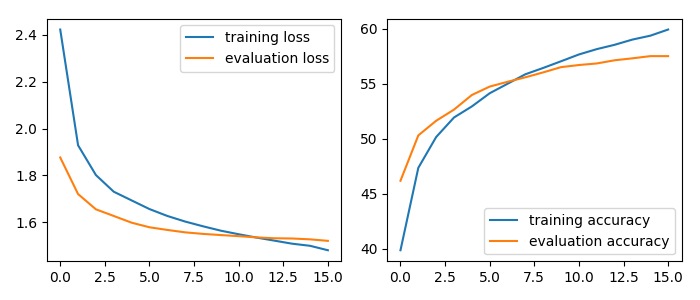

Start/Continue training from epoch 16


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


loss 1.404998779296875
accuracy: tensor(0.6641, device='cuda:0')
Epoch 16 Iter 0 (Time: 2.72s)
loss 1.2836726903915405
accuracy: tensor(0.6477, device='cuda:0')
Epoch 16 Iter 1 (Time: 1.35s)
loss 1.5836071968078613
accuracy: tensor(0.5938, device='cuda:0')
Epoch 16 Iter 2 (Time: 1.38s)
loss 1.413924217224121
accuracy: tensor(0.6242, device='cuda:0')
Epoch 16 Iter 3 (Time: 1.45s)
loss 1.3772525787353516
accuracy: tensor(0.7141, device='cuda:0')
Epoch 16 Iter 4 (Time: 1.46s)
loss 1.3122098445892334
accuracy: tensor(0.6477, device='cuda:0')
Epoch 16 Iter 5 (Time: 1.30s)
loss 1.5066275596618652
accuracy: tensor(0.6156, device='cuda:0')
Epoch 16 Iter 6 (Time: 1.20s)
loss 1.5345826148986816
accuracy: tensor(0.5695, device='cuda:0')
Epoch 16 Iter 7 (Time: 1.34s)
loss 1.4702540636062622
accuracy: tensor(0.5758, device='cuda:0')
Epoch 16 Iter 8 (Time: 1.50s)
loss 1.413865327835083
accuracy: tensor(0.6016, device='cuda:0')
Epoch 16 Iter 9 (Time: 1.38s)
loss 1.4345788955688477
accuracy: tensor(0.

KeyboardInterrupt: 

In [37]:
fig, axes = plt.subplots(ncols=2, figsize=(7, 3))
exp.run(num_epochs=20, plot=lambda exp: plot(exp, fig=fig, axes=axes))